In [ ]:
# Steps involved in the notebook
# 1. Cleaning the tweets(removing all the emojis, special character and lower casing the text)
# 2. Tokenizing the data:
#    1. Word-Vec
#    2. Bert-Tokenization
# 3. Splitting the tweets into labelled and unlabelled data and further splitting them into train, test and split
# 4.  Semi-supervised learning - 
#     1. SVM
#     2. Random Forrest
#     3. XGBoost Classifier
#     3. BERT

#Inporting and Downloading the Libraries

In [1]:
!pip install emoji
!pip  install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 15.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=531877e7e9d8da6811231070cec2a650580ff8ba31db6baf624d985c90b8f399
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 83.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 19.6 MB/s eta 0:00:00


In [2]:
#general purpose packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#data processing
import re, string
import emoji
import nltk

from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#transformers
from transformers import BertTokenizerFast
from transformers import TFBertModel

#keras
import tensorflow as tf
from tensorflow import keras
#metrics
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

#set seed for reproducibility
seed=42

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

<Figure size 432x288 with 0 Axes>

In [3]:
import warnings
warnings.simplefilter('ignore') #we don't wanna see that
np.random.seed(1) #i'm locking seed at the begining since we will use some heavy RNG stuff, be aware

In [4]:
# Modules to display full columns and cells
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [5]:
# To modules to clean up texts
import nltk.data
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('wordnet')
nltk.download('punkt')
tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
# For Word Embedding
from collections import Counter
import gensim
import gensim.models as g
from gensim.models import Word2Vec
from gensim.models import Phrases

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt

In [7]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

In [8]:
# download the model and return as object ready for use
# model_glove_twitter = api.load("glove-twitter-50")

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
from sklearn.metrics import roc_auc_score

# Cleaning the Data

In [10]:
data = pd.read_excel('./oxygen_related_COVID_tweets.xlsx')

In [11]:
data.head()

,Unnamed: 0,text,label
0,0,@jackmathers4 @JaniceDean How about the vaccines? Ventilators? At least President Trump was able to get a stimulus check out.,0.0
1,1,@fordnation Imagine the most populous province wasn't? All cylinders...great. Now we know you're going to fuck this up. #FordfailedOntario,-1.0
2,2,@arunbajpairajan Ye bhi nhi pta hota ki iopec countries ka loan kitna h. Cylinder kitne din me aayega. Ye sab bhi questions the.,-1.0
3,3,@CalapooiaRiver @patteepoo @Ilovezaatar @DC_Draino @hodgetwins @CPAC @Hyatt Yeah...no. Oxygen can get through your mask right? What makes you think a virus can’t??,0.0
4,4,@NotHoodlum Or in a wheelchair....with Oxygen,0.0


In [12]:
# Dropping duplicates tweets
data.drop_duplicates(subset='text',inplace = True)
data.drop(columns=['Unnamed: 0'], inplace = True)

In [13]:
data.head()

,text,label
0,@jackmathers4 @JaniceDean How about the vaccines? Ventilators? At least President Trump was able to get a stimulus check out.,0.0
1,@fordnation Imagine the most populous province wasn't? All cylinders...great. Now we know you're going to fuck this up. #FordfailedOntario,-1.0
2,@arunbajpairajan Ye bhi nhi pta hota ki iopec countries ka loan kitna h. Cylinder kitne din me aayega. Ye sab bhi questions the.,-1.0
3,@CalapooiaRiver @patteepoo @Ilovezaatar @DC_Draino @hodgetwins @CPAC @Hyatt Yeah...no. Oxygen can get through your mask right? What makes you think a virus can’t??,0.0
4,@NotHoodlum Or in a wheelchair....with Oxygen,0.0


In [14]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

#Clean emojis from text
def strip_emoji(text):
    return re.sub(emoji_pattern, r"", text) #remove emoji

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [15]:
texts_new = []
for t in data.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(str(t)))))))

In [16]:
data['text_clean'] = texts_new

In [17]:
data.head()

,text,label,text_clean
0,@jackmathers4 @JaniceDean How about the vaccines? Ventilators? At least President Trump was able to get a stimulus check out.,0.0,how about the vaccines ventilators at least president trump was able to get a stimulus check out
1,@fordnation Imagine the most populous province wasn't? All cylinders...great. Now we know you're going to fuck this up. #FordfailedOntario,-1.0,imagine the most populous province wasnt all cylindersgreat now we know youre going to fuck this up fordfailedontario
2,@arunbajpairajan Ye bhi nhi pta hota ki iopec countries ka loan kitna h. Cylinder kitne din me aayega. Ye sab bhi questions the.,-1.0,ye bhi nhi pta hota ki iopec countries ka loan kitna h cylinder kitne din me aayega ye sab bhi questions the
3,@CalapooiaRiver @patteepoo @Ilovezaatar @DC_Draino @hodgetwins @CPAC @Hyatt Yeah...no. Oxygen can get through your mask right? What makes you think a virus can’t??,0.0,yeahno oxygen can get through your mask right what makes you think a virus cant
4,@NotHoodlum Or in a wheelchair....with Oxygen,0.0,or in a wheelchairwith oxygen


In [18]:
text_len = []
for text in data.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [19]:
data['text_len'] = text_len

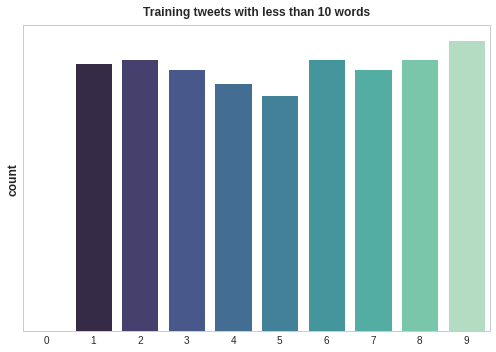

In [20]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=data[data['text_len']<10], palette='mako')
plt.title('Training tweets with less than 10 words')
plt.yticks([])
# ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

#Tokenization

In [21]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [22]:
type(list(data.text_clean))

list

In [23]:
data['tokenized_tweets'] = data['text_clean'].apply(lambda x: x.split()) 

In [24]:
from nltk.corpus import stopwords
filtered_words = []
for t in list(data.tokenized_tweets) :
  k = [words for words in t if not words.lower() in set(stopwords.words('english'))]
  filtered_words.append(k)
data['filtered_tweets'] = filtered_words

In [25]:
data.head()

,text,label,text_clean,text_len,tokenized_tweets,filtered_tweets
0,@jackmathers4 @JaniceDean How about the vaccines? Ventilators? At least President Trump was able to get a stimulus check out.,0.0,how about the vaccines ventilators at least president trump was able to get a stimulus check out,17,"[how, about, the, vaccines, ventilators, at, least, president, trump, was, able, to, get, a, stimulus, check, out]","[vaccines, ventilators, least, president, trump, able, get, stimulus, check]"
1,@fordnation Imagine the most populous province wasn't? All cylinders...great. Now we know you're going to fuck this up. #FordfailedOntario,-1.0,imagine the most populous province wasnt all cylindersgreat now we know youre going to fuck this up fordfailedontario,18,"[imagine, the, most, populous, province, wasnt, all, cylindersgreat, now, we, know, youre, going, to, fuck, this, up, fordfailedontario]","[imagine, populous, province, wasnt, cylindersgreat, know, youre, going, fuck, fordfailedontario]"
2,@arunbajpairajan Ye bhi nhi pta hota ki iopec countries ka loan kitna h. Cylinder kitne din me aayega. Ye sab bhi questions the.,-1.0,ye bhi nhi pta hota ki iopec countries ka loan kitna h cylinder kitne din me aayega ye sab bhi questions the,22,"[ye, bhi, nhi, pta, hota, ki, iopec, countries, ka, loan, kitna, h, cylinder, kitne, din, me, aayega, ye, sab, bhi, questions, the]","[ye, bhi, nhi, pta, hota, ki, iopec, countries, ka, loan, kitna, h, cylinder, kitne, din, aayega, ye, sab, bhi, questions]"
3,@CalapooiaRiver @patteepoo @Ilovezaatar @DC_Draino @hodgetwins @CPAC @Hyatt Yeah...no. Oxygen can get through your mask right? What makes you think a virus can’t??,0.0,yeahno oxygen can get through your mask right what makes you think a virus cant,15,"[yeahno, oxygen, can, get, through, your, mask, right, what, makes, you, think, a, virus, cant]","[yeahno, oxygen, get, mask, right, makes, think, virus, cant]"
4,@NotHoodlum Or in a wheelchair....with Oxygen,0.0,or in a wheelchairwith oxygen,5,"[or, in, a, wheelchairwith, oxygen]","[wheelchairwith, oxygen]"


In [26]:
data.to_csv('data3.csv')

In [27]:
# data = pd.read_csv('/content/data3.csv')

In [28]:
data['filtered_tweets2'] = data['filtered_tweets'].apply(lambda x: ' '.join(x))

In [29]:
data.head()

,text,label,text_clean,text_len,tokenized_tweets,filtered_tweets,filtered_tweets2
0,@jackmathers4 @JaniceDean How about the vaccines? Ventilators? At least President Trump was able to get a stimulus check out.,0.0,how about the vaccines ventilators at least president trump was able to get a stimulus check out,17,"[how, about, the, vaccines, ventilators, at, least, president, trump, was, able, to, get, a, stimulus, check, out]","[vaccines, ventilators, least, president, trump, able, get, stimulus, check]",vaccines ventilators least president trump able get stimulus check
1,@fordnation Imagine the most populous province wasn't? All cylinders...great. Now we know you're going to fuck this up. #FordfailedOntario,-1.0,imagine the most populous province wasnt all cylindersgreat now we know youre going to fuck this up fordfailedontario,18,"[imagine, the, most, populous, province, wasnt, all, cylindersgreat, now, we, know, youre, going, to, fuck, this, up, fordfailedontario]","[imagine, populous, province, wasnt, cylindersgreat, know, youre, going, fuck, fordfailedontario]",imagine populous province wasnt cylindersgreat know youre going fuck fordfailedontario
2,@arunbajpairajan Ye bhi nhi pta hota ki iopec countries ka loan kitna h. Cylinder kitne din me aayega. Ye sab bhi questions the.,-1.0,ye bhi nhi pta hota ki iopec countries ka loan kitna h cylinder kitne din me aayega ye sab bhi questions the,22,"[ye, bhi, nhi, pta, hota, ki, iopec, countries, ka, loan, kitna, h, cylinder, kitne, din, me, aayega, ye, sab, bhi, questions, the]","[ye, bhi, nhi, pta, hota, ki, iopec, countries, ka, loan, kitna, h, cylinder, kitne, din, aayega, ye, sab, bhi, questions]",ye bhi nhi pta hota ki iopec countries ka loan kitna h cylinder kitne din aayega ye sab bhi questions
3,@CalapooiaRiver @patteepoo @Ilovezaatar @DC_Draino @hodgetwins @CPAC @Hyatt Yeah...no. Oxygen can get through your mask right? What makes you think a virus can’t??,0.0,yeahno oxygen can get through your mask right what makes you think a virus cant,15,"[yeahno, oxygen, can, get, through, your, mask, right, what, makes, you, think, a, virus, cant]","[yeahno, oxygen, get, mask, right, makes, think, virus, cant]",yeahno oxygen get mask right makes think virus cant
4,@NotHoodlum Or in a wheelchair....with Oxygen,0.0,or in a wheelchairwith oxygen,5,"[or, in, a, wheelchairwith, oxygen]","[wheelchairwith, oxygen]",wheelchairwith oxygen


In [30]:
# Downloading stopwords
from nltk.corpus import stopwords
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [31]:
# Initializing WordnetLemmatizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [32]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [33]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [34]:
lemmatized_tweets = []
for w in data.filtered_tweets:
  k = [lemmatizer.lemmatize(t) for t in w]
  lemmatized_tweets.append(k)
data['lemmatized_tweets'] = lemmatized_tweets
data['lemmatized_tweets2'] = data['lemmatized_tweets'].apply(lambda x: " ".join(x))

In [35]:
data.head()

,text,label,text_clean,text_len,tokenized_tweets,filtered_tweets,filtered_tweets2,lemmatized_tweets,lemmatized_tweets2
0,@jackmathers4 @JaniceDean How about the vaccines? Ventilators? At least President Trump was able to get a stimulus check out.,0.0,how about the vaccines ventilators at least president trump was able to get a stimulus check out,17,"[how, about, the, vaccines, ventilators, at, least, president, trump, was, able, to, get, a, stimulus, check, out]","[vaccines, ventilators, least, president, trump, able, get, stimulus, check]",vaccines ventilators least president trump able get stimulus check,"[vaccine, ventilator, least, president, trump, able, get, stimulus, check]",vaccine ventilator least president trump able get stimulus check
1,@fordnation Imagine the most populous province wasn't? All cylinders...great. Now we know you're going to fuck this up. #FordfailedOntario,-1.0,imagine the most populous province wasnt all cylindersgreat now we know youre going to fuck this up fordfailedontario,18,"[imagine, the, most, populous, province, wasnt, all, cylindersgreat, now, we, know, youre, going, to, fuck, this, up, fordfailedontario]","[imagine, populous, province, wasnt, cylindersgreat, know, youre, going, fuck, fordfailedontario]",imagine populous province wasnt cylindersgreat know youre going fuck fordfailedontario,"[imagine, populous, province, wasnt, cylindersgreat, know, youre, going, fuck, fordfailedontario]",imagine populous province wasnt cylindersgreat know youre going fuck fordfailedontario
2,@arunbajpairajan Ye bhi nhi pta hota ki iopec countries ka loan kitna h. Cylinder kitne din me aayega. Ye sab bhi questions the.,-1.0,ye bhi nhi pta hota ki iopec countries ka loan kitna h cylinder kitne din me aayega ye sab bhi questions the,22,"[ye, bhi, nhi, pta, hota, ki, iopec, countries, ka, loan, kitna, h, cylinder, kitne, din, me, aayega, ye, sab, bhi, questions, the]","[ye, bhi, nhi, pta, hota, ki, iopec, countries, ka, loan, kitna, h, cylinder, kitne, din, aayega, ye, sab, bhi, questions]",ye bhi nhi pta hota ki iopec countries ka loan kitna h cylinder kitne din aayega ye sab bhi questions,"[ye, bhi, nhi, pta, hota, ki, iopec, country, ka, loan, kitna, h, cylinder, kitne, din, aayega, ye, sab, bhi, question]",ye bhi nhi pta hota ki iopec country ka loan kitna h cylinder kitne din aayega ye sab bhi question
3,@CalapooiaRiver @patteepoo @Ilovezaatar @DC_Draino @hodgetwins @CPAC @Hyatt Yeah...no. Oxygen can get through your mask right? What makes you think a virus can’t??,0.0,yeahno oxygen can get through your mask right what makes you think a virus cant,15,"[yeahno, oxygen, can, get, through, your, mask, right, what, makes, you, think, a, virus, cant]","[yeahno, oxygen, get, mask, right, makes, think, virus, cant]",yeahno oxygen get mask right makes think virus cant,"[yeahno, oxygen, get, mask, right, make, think, virus, cant]",yeahno oxygen get mask right make think virus cant
4,@NotHoodlum Or in a wheelchair....with Oxygen,0.0,or in a wheelchairwith oxygen,5,"[or, in, a, wheelchairwith, oxygen]","[wheelchairwith, oxygen]",wheelchairwith oxygen,"[wheelchairwith, oxygen]",wheelchairwith oxygen


In [36]:
data.to_csv('data4.csv')

In [37]:
# data = pd.read_csv('data4.csv')

In [38]:
# Columns name
data.columns

Index(['text', 'label', 'text_clean', 'text_len', 'tokenized_tweets',
       'filtered_tweets', 'filtered_tweets2', 'lemmatized_tweets',
       'lemmatized_tweets2'],
      dtype='object')

##Word-Vec

In [39]:
data.head()

,text,label,text_clean,text_len,tokenized_tweets,filtered_tweets,filtered_tweets2,lemmatized_tweets,lemmatized_tweets2
0,@jackmathers4 @JaniceDean How about the vaccines? Ventilators? At least President Trump was able to get a stimulus check out.,0.0,how about the vaccines ventilators at least president trump was able to get a stimulus check out,17,"[how, about, the, vaccines, ventilators, at, least, president, trump, was, able, to, get, a, stimulus, check, out]","[vaccines, ventilators, least, president, trump, able, get, stimulus, check]",vaccines ventilators least president trump able get stimulus check,"[vaccine, ventilator, least, president, trump, able, get, stimulus, check]",vaccine ventilator least president trump able get stimulus check
1,@fordnation Imagine the most populous province wasn't? All cylinders...great. Now we know you're going to fuck this up. #FordfailedOntario,-1.0,imagine the most populous province wasnt all cylindersgreat now we know youre going to fuck this up fordfailedontario,18,"[imagine, the, most, populous, province, wasnt, all, cylindersgreat, now, we, know, youre, going, to, fuck, this, up, fordfailedontario]","[imagine, populous, province, wasnt, cylindersgreat, know, youre, going, fuck, fordfailedontario]",imagine populous province wasnt cylindersgreat know youre going fuck fordfailedontario,"[imagine, populous, province, wasnt, cylindersgreat, know, youre, going, fuck, fordfailedontario]",imagine populous province wasnt cylindersgreat know youre going fuck fordfailedontario
2,@arunbajpairajan Ye bhi nhi pta hota ki iopec countries ka loan kitna h. Cylinder kitne din me aayega. Ye sab bhi questions the.,-1.0,ye bhi nhi pta hota ki iopec countries ka loan kitna h cylinder kitne din me aayega ye sab bhi questions the,22,"[ye, bhi, nhi, pta, hota, ki, iopec, countries, ka, loan, kitna, h, cylinder, kitne, din, me, aayega, ye, sab, bhi, questions, the]","[ye, bhi, nhi, pta, hota, ki, iopec, countries, ka, loan, kitna, h, cylinder, kitne, din, aayega, ye, sab, bhi, questions]",ye bhi nhi pta hota ki iopec countries ka loan kitna h cylinder kitne din aayega ye sab bhi questions,"[ye, bhi, nhi, pta, hota, ki, iopec, country, ka, loan, kitna, h, cylinder, kitne, din, aayega, ye, sab, bhi, question]",ye bhi nhi pta hota ki iopec country ka loan kitna h cylinder kitne din aayega ye sab bhi question
3,@CalapooiaRiver @patteepoo @Ilovezaatar @DC_Draino @hodgetwins @CPAC @Hyatt Yeah...no. Oxygen can get through your mask right? What makes you think a virus can’t??,0.0,yeahno oxygen can get through your mask right what makes you think a virus cant,15,"[yeahno, oxygen, can, get, through, your, mask, right, what, makes, you, think, a, virus, cant]","[yeahno, oxygen, get, mask, right, makes, think, virus, cant]",yeahno oxygen get mask right makes think virus cant,"[yeahno, oxygen, get, mask, right, make, think, virus, cant]",yeahno oxygen get mask right make think virus cant
4,@NotHoodlum Or in a wheelchair....with Oxygen,0.0,or in a wheelchairwith oxygen,5,"[or, in, a, wheelchairwith, oxygen]","[wheelchairwith, oxygen]",wheelchairwith oxygen,"[wheelchairwith, oxygen]",wheelchairwith oxygen


In [40]:
# making column containing tweets where number are removed
not_int = []
for cell in data.lemmatized_tweets:
  t = [w for w in cell if not w.isdigit() ]
  not_int.append(t)
data['not_integer'] = not_int 

In [41]:
tokenized_tweet = data['lemmatized_tweets'].copy()

In [42]:
# Making the wordvec model
model_w2v = gensim.models.Word2Vec(tokenized_tweet, size=200,window = 5,min_count = 2, sg= 1,hs = 0, negative = 10, workers =8, seed =34)
model_w2v.train(tokenized_tweet,total_examples = len(data['lemmatized_tweets']),epochs=20)
# model_w2v = api.load('/content/model1')

(17423727, 20695520)

In [43]:
model_w2v.save('model1')

In [44]:
# function for converting the tweets into wordvec tokens
def word_vector(tokens, size,i):
  vec = np.zeros(size).reshape((1,size))
  count = 0 
  for word in tokens:
    try:
      vec += model_w2v[word].reshape((1,size))
      count += 1
    except KeyError :
      # print('whatsupp')
      # print(i,tokens)
      continue
      # pass
  if count != 0:
    vec /= count
    return vec

In [45]:
range(len(tokenized_tweet))

range(0, 74355)

In [46]:
# DataFrame containg the wordvec tokens of twweets
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))
count1 = 0
for i in range(len(tokenized_tweet)) :
  try :
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200,i)
    wordvec_df = pd.DataFrame(wordvec_arrays)
  except KeyError :
    # print(i,'KeyError')
    count1+=1
    continue
print(count1)  
wordvec_df.shape

2705


(74355, 200)

In [47]:
data.shape

(74355, 10)

In [48]:
# All words are converted into the word vectors
wordvec_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,-0.098515,0.063308,-0.328059,0.571026,-0.033459,0.187666,0.021455,0.087152,-0.238164,0.180368,-0.018608,-0.002665,-0.282139,-0.112194,-0.183995,-0.076674,0.042755,-0.143772,-0.001198,-0.078169,-0.098653,-0.172908,0.038607,0.285406,0.071050,0.092312,0.054673,0.308156,0.059504,-0.345924,0.041939,-0.140317,0.134299,0.104310,0.015366,-0.054316,-0.042701,-0.218505,-0.317598,0.188485,-0.533589,0.351365,0.027690,-0.078516,-0.020905,-0.022276,0.405276,0.139875,-0.139567,0.066164,-0.272408,-0.097598,0.044391,-0.019141,-0.071813,0.040489,-0.071907,0.236926,-0.041314,-0.200191,-0.154990,-0.163139,0.046414,-0.381730,0.023698,0.079079,-0.215209,-0.197440,0.039220,-0.211744,-0.352135,0.098199,-0.366380,-0.036879,-0.452626,0.142561,0.001073,-0.153455,-0.042358,-0.082690,0.096017,-0.129125,0.088239,0.104304,-0.191398,-0.159013,-0.276768,-0.035721,0.145224,0.377309,0.260807,0.117432,-0.116749,0.014454,-0.024387,-0.181191,0.340448,-0.131289,0.083872,-0.078759,0.173397,0.130022,0.163331,-0.072502,0.201510,-0.012427,-0.088385,0.372667,-0.065691,-0.052759,0.133472,0.015331,-0.273898,0.323548,0.099113,-0.147818,0.098583,-0.036035,-0.058796,0.033135,-0.262434,-0.078577,0.032432,0.252816,0.042408,0.005031,0.143330,-0.230423,-0.019234,0.108178,-0.164121,-0.351230,0.029954,-0.365878,-0.022750,0.097662,-0.059436,0.272876,-0.165944,-0.241685,0.059381,-0.067856,-0.092375,-0.047369,0.074763,0.085460,0.255616,0.210930,0.174732,-0.028821,-0.009151,0.003454,0.139249,0.066419,0.014127,0.055080,0.036199,0.082512,0.011320,0.141964,0.063366,-0.017749,-0.333914,0.280322,-0.117294,-0.047767,0.046948,-0.040621,-0.254150,-0.093951,0.298019,0.049146,0.084523,-0.219264,-0.056533,-0.015165,-0.419894,0.097152,-0.380628,-0.040503,-0.160584,-0.251280,-0.075498,0.077772,0.268090,-0.062108,-0.252308,0.157672,-0.121255,0.036919,-0.220215,0.309889,0.078060,-0.015261,0.247126,-0.138019,-0.102803,-0.113181,0.207263,-0.131741
1,-0.106894,0.302962,-0.406337,0.453237,-0.071846,0.023083,0.030679,0.131461,-0.265834,0.173849,-0.054426,0.105727,-0.142327,0.216217,-0.106679,0.026509,0.317434,-0.126483,0.072257,-0.155219,-0.009903,-0.176760,0.113388,-0.036024,-0.156075,0.417255,-0.215252,0.128305,0.285865,-0.052229,0.087195,-0.026435,0.071750,0.263156,0.178356,0.186290,-0.177881,-0.288062,-0.426293,0.367559,-0.546819,0.478293,0.076123,-0.121338,0.001553,-0.180000,0.059107,0.344476,-0.015254,-0.016713,-0.615407,-0.035267,-0.065586,-0.054568,0.113019,0.091463,-0.393209,0.312741,-0.033536,-0.254353,-0.110037,-0.039532,0.409132,-0.365701,0.011612,0.270490,-0.005502,-0.034718,0.204599,-0.291371,-0.086120,-0.022446,-0.326524,0.001446,-0.366042,0.203244,-0.138913,0.043209,0.175171,-0.043447,0.015482,-0.014716,0.206144,0.026126,-0.148348,-0.046986,-0.174326,-0.004383,-0.061555,0.263206,0.047162,0.172802,-0.223524,-0.039713,0.004033,-0.062140,0.217095,-0.118269,0.147341,0.021125,0.069667,-0.005495,0.289276,0.116266,-0.083894,-0.077334,-0.096184,0.443044,-0.317784,-0.001315,0.200698,0.152995,-0.159820,0.301663,0.002972,-0.021998,0.095926,-0.355067,0.050188,-0.009446,-0.131169,0.226396,-0.045492,0.239780,0.124652,-0.003973,0.035641,-0.102659,0.026101,-0.158720,-0.185433,-0.125431,0.105439,-0.307524,0.021774,0.003860,-0.255006,0.229324,-0.149488,-0.259416,0.097093,-0.158090,-0.120013,-0.005192,0.231838,0.065457,0.032385

##Bert-Tokenization

In [49]:
# Downloading the Bert pretrained models
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
token_lens = []

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [50]:
# Taking the lenght of the tokenized tweets
for txt in data['lemmatized_tweets2'].values:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

max_len=np.max(token_lens)

In [51]:
max_len

126

In [52]:
data['token_lens'] = token_lens

In [53]:
data['label'].value_counts()

 0.0    152
-1.0     99
 1.0     63
Name: label, dtype: int64

In [54]:
X = wordvec_df.copy()
y = data['label'].copy().fillna(5)

In [55]:
y.isnull().sum()

0

In [56]:
X.shape

(74355, 200)

In [57]:
y.shape

(74355,)

In [58]:
X['target'] = y.copy()

In [59]:
X['target'].value_counts()

 5.0    71336
 0.0      152
-1.0       99
 1.0       63
Name: target, dtype: int64

In [60]:
X['target'].isnull().sum()

2705

In [61]:
X.loc[X['target'].isnull(),:]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,target
76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
471,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
702,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [62]:
X = X.loc[X['target'].notnull(),:].copy()

In [63]:
X = X.loc[X[1].notnull(),:].copy()

In [64]:
y = X['target'].copy()

In [65]:
X.drop(columns=['target'],inplace = True)

In [66]:
X.shape

(71545, 200)

#Splitting the data

In [67]:
X['target'] = y.copy()

In [68]:
X['target'].isnull().sum()

0

In [69]:
X_train = X.loc[X['target']!=5,:]
X_test = X.loc[X['target']==5,:]

In [70]:
X_train.shape,X_test.shape

((314, 201), (71231, 201))

In [71]:
y_train = X_train['target']
y_test = X_test['target']

In [72]:
X_train.drop(columns=['target'],inplace=True)
X_test.drop(columns=['target'],inplace=True)

#Semi- Supervised Models

##SVM

In [87]:
from sklearn.svm import SVC
svm = SVC()
X_train,X_valid,y_train,y_valid1 = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)
svm.fit( X_train, y_train)
pred2 = svm.predict(X_test)
pred2 = pd.DataFrame(pred2)
final_data_y = [y_train, pred2]
final_data_x = [X_train, X_test]
final_data_y = pd.concat(final_data_y)
final_data_x = pd.concat(final_data_x)
svm.fit(final_data_x, final_data_y)
final_pred_1 = svm.predict(X_train)
print('Validation Score is ', accuracy_score(y_valid1, pd.DataFrame(svm.predict(X_valid))))
print('Accuracy Score on labelled data ', accuracy_score(y_train, final_pred_1))

Validation Score is  0.8227848101265823
Accuracy Score on labelled data  0.8808510638297873


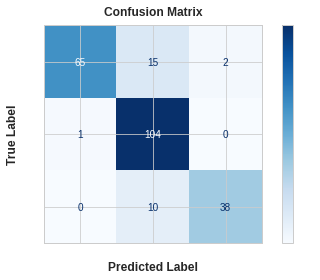

In [88]:
# Confusion Matrix on SVM
from sklearn.metrics import plot_confusion_matrix
sns.reset_orig 
color = 'white'
matrix = plot_confusion_matrix(svm, X_train, y_train, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

##Random Forest

In [89]:
# Importing the RandomForest Classifier model and traing the labelled data then joining both labelled and unlabbeled data to train the model on large data
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier()
X_train,X_valid,y_train,y_valid = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)
classifier.fit(X_train,y_train)
pred = classifier.predict(X_test)
pred = pd.DataFrame(pred)
X_t = pd.concat([X_train,X_test])
Y_t = pd.concat([y_train,pred])
classifier.fit(X_t,Y_t)
# accuracy score on validation set
print('Accuracy Score of validation Set ', accuracy_score(y_valid, pd.DataFrame(classifier.predict(X_valid))))
# prediction on labelled data
final_pred = classifier.predict(X_train)
# seeing the score on labelled data
score = accuracy_score(y_train,final_pred)
print('Score on labelled data',score)

Accuracy Score of validation Set  0.7457627118644068
Score on labelled data 1.0


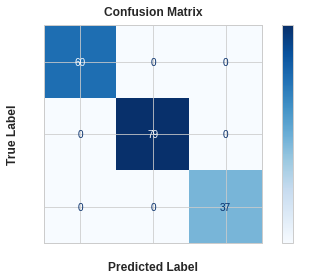

In [90]:
# Confusion Matrix on random Forrest
from sklearn.metrics import plot_confusion_matrix
sns.reset_orig 
color = 'white'
matrix = plot_confusion_matrix(classifier, X_train, y_train, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

##XGBOOST

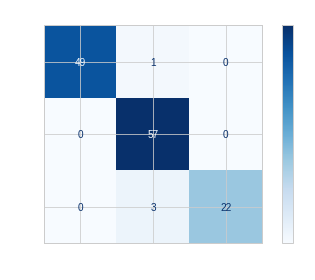

In [91]:
from xgboost import XGBClassifier
X_train,X_valid,y_train,y_valid = train_test_split(X_train, y_train, test_size=0.25, shuffle=True)
xgbclassifier = XGBClassifier()
xgbclassifier.fit( X_train, y_train)
xgb_pred = xgbclassifier.predict(X_test)
xgb_pred = pd.DataFrame(xgb_pred)
frames1 = [X_train, X_test]
labels1 = [y_train, xgb_pred]
X_tweets = pd.concat(frames1)
Y_tweets = pd.concat(labels1)
xgbclassifier.fit( X_tweets,Y_tweets)
xgb_pred_final = xgbclassifier.predict(X_train)
from sklearn.metrics import plot_confusion_matrix
 
color = 'white'
matrix = plot_confusion_matrix(xgbclassifier, X_train, y_train, cmap=plt.cm.Blues)
matrix.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()

In [92]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_train, xgb_pred_final)

In [93]:
valid_score = accuracy_score(y_valid, pd.DataFrame(xgbclassifier.predict(X_valid)))
print('accuracy score on valid set ', valid_score)

accuracy score on valid set  0.6818181818181818


In [94]:
print('accuracy score on labelleda data', score)

accuracy score on labelleda data 0.9696969696969697


##BERT

In [95]:
MAX_LEN=126

In [96]:
# Function to tokenize the tweets into bert tokens
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [97]:
data

,text,label,text_clean,text_len,tokenized_tweets,filtered_tweets,filtered_tweets2,lemmatized_tweets,lemmatized_tweets2,not_integer,token_lens
0,@jackmathers4 @JaniceDean How about the vaccines? Ventilators? At least President Trump was able to get a stimulus check out.,0.0,how about the vaccines ventilators at least president trump was able to get a stimulus check out,17,"[how, about, the, vaccines, ventilators, at, least, president, trump, was, able, to, get, a, stimulus, check, out]","[vaccines, ventilators, least, president, trump, able, get, stimulus, check]",vaccines ventilators least president trump able get stimulus check,"[vaccine, ventilator, least, president, trump, able, get, stimulus, check]",vaccine ventilator least president trump able get stimulus check,"[vaccine, ventilator, least, president, trump, able, get, stimulus, check]",13
1,@fordnation Imagine the most populous province wasn't? All cylinders...great. Now we know you're going to fuck this up. #FordfailedOntario,-1.0,imagine the most populous province wasnt all cylindersgreat now we know youre going to fuck this up fordfailedontario,18,"[imagine, the, most, populous, province, wasnt, all, cylindersgreat, now, we, know, youre, going, to, fuck, this, up, fordfailedontario]","[imagine, populous, province, wasnt, cylindersgreat, know, youre, going, fuck, fordfailedontario]",imagine populous province wasnt cylindersgreat know youre going fuck fordfailedontario,"[imagine, populous, province, wasnt, cylindersgreat, know, youre, going, fuck, fordfailedontario]",imagine populous province wasnt cylindersgreat know youre going fuck fordfailedontario,"[imagine, populous, province, wasnt, cylindersgreat, know, youre, going, fuck, fordfailedontario]",20
2,@arunbajpairajan Ye bhi nhi pta hota ki iopec countries ka loan kitna h. Cylinder kitne din me aayega. Ye sab bhi questions the.,-1.0,ye bhi nhi pta hota ki iopec countries ka loan kitna h cylinder kitne din me aayega ye sab bhi questions the,22,"[ye, bhi, nhi, pta, hota, ki, iopec, countries, ka, loan, kitna, h, cylinder, kitne, din, me, aayega, ye, sab, bhi, questions, the]","[ye, bhi, nhi, pta, hota, ki, iopec, countries, ka, loan, kitna, h, cylinder, kitne, din, aayega, ye, sab, bhi, questions]",ye bhi nhi pta hota ki iopec countries ka loan kitna h cylinder kitne din aayega ye sab bhi questions,"[ye, bhi, nhi, pta, hota, ki, iopec, country, ka, loan, kitna, h, cylinder, kitne, din, aayega, ye, sab, bhi, question]",ye bhi nhi pta hota ki iopec country ka loan kitna h cylinder kitne din aayega ye sab bhi question,"[ye, bhi, nhi, pta, hota, ki, iopec, country, ka, loan, kitna, h, cylinder, kitne, din, aayega, ye, sab, bhi, question]",34
3,@CalapooiaRiver @patteepoo @Ilovezaatar @DC_Draino @hodgetwins @CPAC @Hyatt Yeah...no. Oxygen can get through your mask right? What makes you think a virus can’t??,0.0,yeahno oxygen can get through your mask right what makes you think a virus cant,15,"[yeahno, oxygen, can, get, through, your, mask, right, what, makes, you, think, a, virus, cant]","[yeahno, oxygen, get, mask, right, makes, think, virus, cant]",yeahno oxygen get mask right makes think virus cant,"[yeahno, oxygen, get, mask, right, make, think, virus, cant]",yeahno oxygen get mask right make think virus cant,"[yeahno, oxygen, get, mask, right, make, think, virus, cant]",13
4,@NotHoodlum Or in a wheelchair....with Oxygen,0.0,or in a wheelchairwith oxygen,5,"[or, in, a, wheelchairwith, oxygen]","[wheelchairwith, oxygen]",wheelchairwith oxygen,"[wheelchairwith, oxygen]",wheelchairwith oxygen,"[wheelchairwith, oxygen]",5
...,...,...,...,...,...,...,...,...,...,...,...
79601,#SonuSood to import Oxygen Plant From France country to India to help COVID-19 Patients! @SonuSood 🙏🏻🇮🇳 https://t.co/cAdupbJb8o,NaN,sonusood to import oxygen plant from france country to india to help covid19 patients,14,"[sonusood, to, import, oxygen, plant, from, france, country, to, india, to, help, covid19, patients]","[sonusood, import, oxygen, p

In [98]:
# Deviding the data into train and test set
X_train1 = data[data['label'].notnull()].copy()
X_test1 = data[data['label'].isnull()].copy()
y_train1 = X_train1['label'].copy()

In [99]:
# Seeing the shape
y_train1.shape

(314,)

In [100]:
# Seeing the differnt types of labelled data
y_train1.value_counts()

 0.0    152
-1.0     99
 1.0     63
Name: label, dtype: int64

In [101]:
X_train1 = X_train1['lemmatized_tweets2'].copy().values
X_test1 = X_test1['lemmatized_tweets2'].copy().values
y_train1 = y_train1.values

In [102]:
X_train1,X_valid1,y_train1,y_valid1 = train_test_split(X_train1, y_train1, test_size=0.25, shuffle=True)

In [103]:
y_train_le = y_train1.copy()
y_valid_le = y_valid1.copy()

In [104]:
# one hot encoding the y data
ohe = preprocessing.OneHotEncoder()
y_train1 = ohe.fit_transform(np.array(y_train1).reshape(-1, 1)).toarray()
y_valid1 = ohe.fit_transform(np.array(y_valid1).reshape(-1, 1)).toarray()

In [105]:
# Tokenizing the train test and validation data
train_input_ids, train_attention_masks = tokenize(X_train1, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid1, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(X_test1, MAX_LEN)

In [106]:
# Splitting the data which has to be predicted due to its too large volume
test = np.array_split(X_test1, 4)

In [107]:
# tokenizing the test data
test_input_ids0, test_attention_masks0 = tokenize(test[0], MAX_LEN)
test_input_ids1, test_attention_masks1 = tokenize(test[1], MAX_LEN)
test_input_ids2, test_attention_masks2 = tokenize(test[2], MAX_LEN)
test_input_ids3, test_attention_masks3 = tokenize(test[3], MAX_LEN)

In [108]:
# Downloading the bert model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [109]:
# Function to create the bert model

def create_model(bert_model, max_len=MAX_LEN):
    
    ##params###
    opt = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-7)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()


    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')
    
    embeddings = bert_model([input_ids,attention_masks])[1]
    
    output = tf.keras.layers.Dense(3, activation="softmax")(embeddings)
    
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)
    
    model.compile(opt, loss=loss, metrics=accuracy)
    
    
    return model


In [110]:
# Model summary
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 126)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 126)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 126,                                           

In [ ]:
# Fitting the model
history_bert = model.fit([train_input_ids,train_attention_masks], y_train1, validation_data=([val_input_ids,val_attention_masks], y_valid1), epochs=4, batch_size=32)

Epoch 1/4
8/8 [==============================] - 373s 44s/step - loss: 1.2064 - categorical_accuracy: 0.2894 - val_loss: 1.1385 - val_categorical_accuracy: 0.2152
Epoch 2/4
8/8 [==============================] - 338s 42s/step - loss: 1.0731 - categorical_accuracy: 0.3745 - val_loss: 1.0428 - val_categorical_accuracy: 0.4810
Epoch 3/4
8/8 [==============================] - 337s 42s/step - loss: 1.0390 - categorical_accuracy: 0.4426 - val_loss: 0.9974 - val_categorical_accuracy: 0.5443
Epoch 4/4


In [127]:
# Predicting the first part out of four of the test data
result_bert0 = model.predict([test_input_ids0,test_attention_masks0])

579/579 [==============================] - 7444s 13s/step


In [134]:
# Converting the first part into dataframe
result1 = pd.DataFrame(result_bert0,columns=['-1','0','1'])

In [135]:
# storing the first part
result1.to_csv('result1.csv')

In [136]:
# Predicting the second part out of four of the test data
result_bert1 = model.predict([test_input_ids1,test_attention_masks1])

579/579 [==============================] - 7575s 13s/step


In [137]:
# Converting the first part into dataframe and storing it
result2 = pd.DataFrame(result_bert1,columns=['-1','0','1'])
result1.to_csv('result2.csv')

In [138]:
# Predicting the third part out of four of the test data
result_bert2 = model.predict([test_input_ids2,test_attention_masks2])

579/579 [==============================] - 7506s 13s/step


In [139]:
# storing it in the dataframe
result3 = pd.DataFrame(result_bert2,columns=['-1','0','1'])
result1.to_csv('result3.csv')

In [ ]:
# predicting the third part
result_bert3 = model.predict([test_input_ids3,test_attention_masks3])

In [ ]:
# storing it 
result4 = pd.DataFrame(result_bert3,columns=['-1','0','1'])
result4.to_csv('result4.csv')

In [ ]:
# Concating all the prediction parts to make one model
result_bert = pd.concat(result_bert0,result_bert1,result_bert2,result_bert3)

In [117]:
"#@title Uploading the above downloaded parts and and combining them into one prediction
# # downloading the different part which are predicted
# result1 = pd.read_csv('result1.csv')
# result2 = pd.read_csv('result2.csv')
# result3 = pd.read_csv('result3.csv')
# result4 = pd.read_csv('result5.csv')

# # Convertring the parts of result nack to numpy array 
# re_1 = result1.drop(columns=['Unnamed: 0']).copy().to_numpy()
# re_2 = result2.drop(columns=['Unnamed: 0']).copy().to_numpy()
# re_3 = result3.drop(columns=['Unnamed: 0']).copy().to_numpy()
# re_4 = result4.drop(columns=['Unnamed: 0']).copy().to_numpy()

# result_bert = np.concatenate((re_1,re_2,re_3,re_4))

In [132]:
result_bert

array([[0.439584  , 0.39654878, 0.16386719],
       [0.3722687 , 0.47844213, 0.14928909],
       [0.17227918, 0.7226148 , 0.10510593],
       ...,
       [0.3410724 , 0.38820517, 0.2707225 ],
       [0.34346217, 0.50232667, 0.15421122],
       [0.31791478, 0.46353114, 0.21855415]])

In [133]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1

In [136]:
# Predicted labels of unlabelled data
y_pred_bert

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [138]:
# Now let see what model predict to the labelled data 
result_bert_train = model.predict([train_input_ids, train_attention_masks])

8/8 [==============================] - 124s 15s/step


In [139]:
y_pred_bert1 =  np.zeros_like(result_bert_train)
y_pred_bert1[np.arange(len(y_pred_bert1)), result_bert_train.argmax(1)] = 1

In [140]:
from sklearn.metrics import classification_report, confusion_matrix

In [144]:
# So confusion matrix to the labelledaq data is
confusion_matrix(y_train1.argmax(1), y_pred_bert1.argmax(1))

array([[  4,  78,   0],
       [  2, 103,   0],
       [  2,  46,   0]])

In [145]:
score = accuracy_score(y_train1,y_pred_bert1)

In [146]:
print(score)

0.4553191489361702
